In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.2 MB/s eta 0:00:00


No Stand and No Op

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3125 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3069 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2793 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3304 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2746 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2926 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3174 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.2673 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


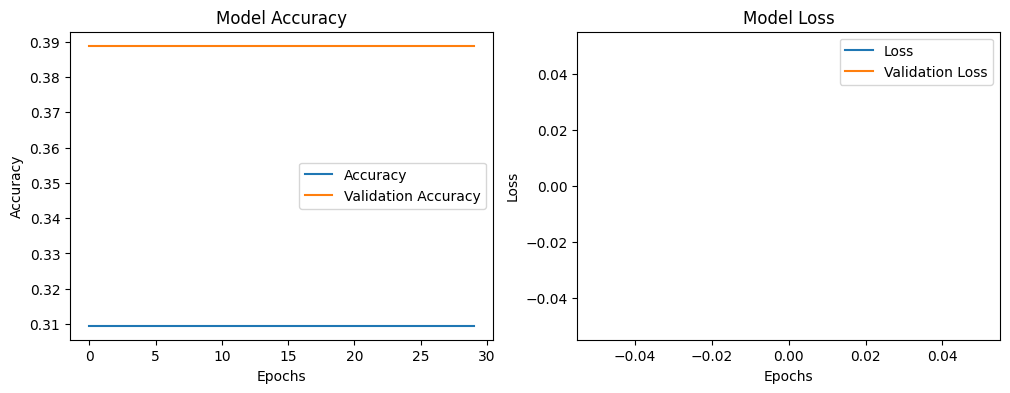

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/No_Options.keras ✅


In [ ]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)

            # Apply wavelet decomposition (db4, level 5)
            coeffs = pywt.wavedec(file_data, 'db4', level=5)  # Decompose using 'db4' wavelet and 5 levels
            # Combine the wavelet coefficients (approximation and details)
            wavelet_features = np.concatenate([coeff.flatten() for coeff in coeffs], axis=0)

            data.append(wavelet_features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=3)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')  # Weighted recall
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With Standerscaler

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 977ms/step - accuracy: 0.4054 - loss: 6.8388 - val_accuracy: 0.6556 - val_loss: 0.7305
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 723ms/step - accuracy: 0.6396 - loss: 0.8638 - val_accuracy: 0.6444 - val_loss: 0.6544
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7730 - loss: 0.6022 - val_accuracy: 0.8333 - val_loss: 0.5162
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 710ms/step - accuracy: 0.8675 - loss: 0.4338 - val_accuracy: 0.9222 - val_loss: 0.3716
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9409 - loss: 0.2769 - val_accuracy: 0.6556 - val_loss: 0.5894
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step - accuracy: 0.9222 - loss: 0.2633 - val_accuracy: 0.8000 - val_loss: 0.3804
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 853ms/step - accuracy: 0.9481 - loss: 0.1617 - val_accuracy: 0.9556 - val_loss: 0.2413
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step - accuracy: 0.9639 - loss: 0.1439 - val_accuracy: 0.9667 - val_loss: 0.185

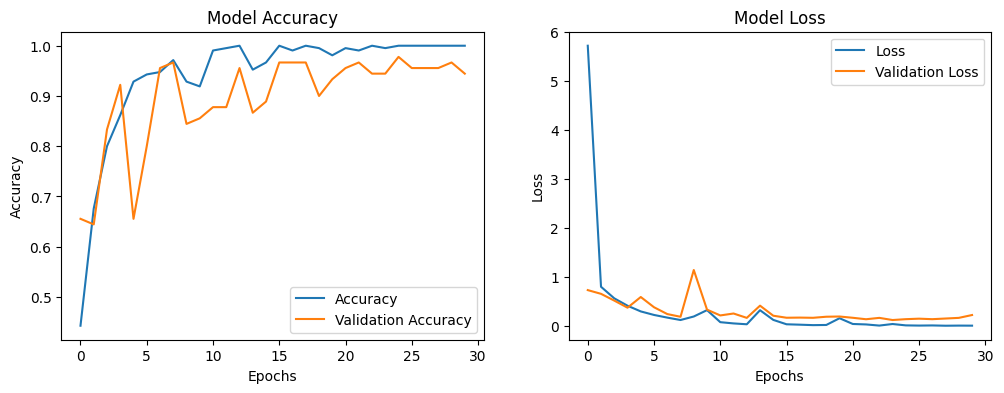

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/With_Stander.keras ✅


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import pywt  # Import pywt for wavelet transformation

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet decomposition (db4, level 5)
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        # Perform wavelet decomposition for each signal in the data
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all wavelet coefficients (approximation + details) into one array
        coeffs_flattened = np.concatenate(coeffs)
        decomposed_data.append(coeffs_flattened)
    return np.array(decomposed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition (db4, level 5)
    data_all_wavelet = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the CNN model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes
    ])

    # Compile the model
    model.compile( loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and track time
    start_time = time.time()
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='macro')
    precision = precision_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time (seconds): ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



With Op

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3101 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3335 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3099 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3064 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2629 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3071 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3013 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2995 - loss: nan - val_accuracy: 0.3889 - val_loss: nan
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2937 

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Evaluation Metrics:
Test Accuracy:  0.3888888888888889
Test Recall (Weighted):  0.3888888888888889
Test Precision (Weighted):  0.15123456790123457
Test F1 Score (Weighted):  0.2177777777777778
Confusion Matrix: 
 [[35  0  0]
 [28  0  0]
 [27  0  0]]
Training Duration (in seconds):  619.9448456764221


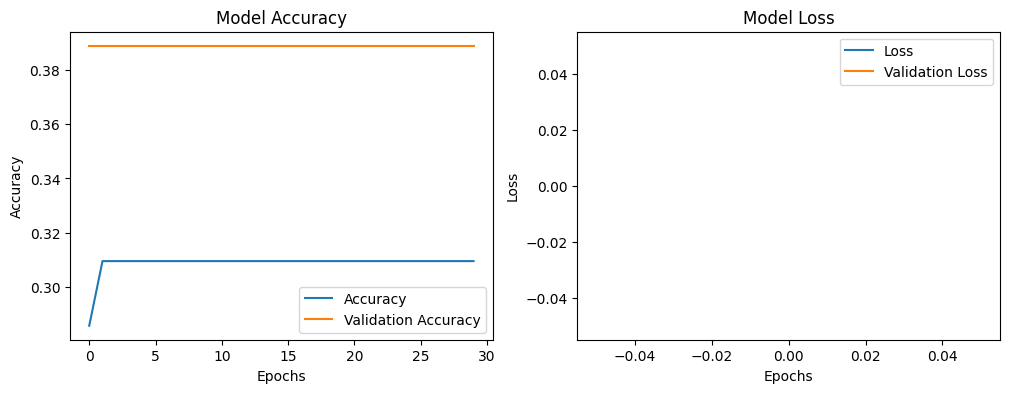

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/With_Optimiser.keras ✅


In [ ]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to perform wavelet decomposition
def wavelet_decomposition(data, wavelet='db4', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Concatenate all coefficients into a single feature vector
    return np.concatenate(coeffs)

# Function to load data and apply wavelet decomposition
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            # Apply wavelet decomposition to each signal (time series data)
            decomposed_data = wavelet_decomposition(file_data)
            data.append(decomposed_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=3)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input (if needed)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')  # Weighted recall
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



with Both

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.3988 - loss: 1.0556 - val_accuracy: 0.3000 - val_loss: 0.9905
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3601 - loss: 0.9308 - val_accuracy: 0.3111 - val_loss: 0.9067
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5083 - loss: 0.8992 - val_accuracy: 0.5556 - val_loss: 0.9036
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4941 - loss: 0.8880 - val_accuracy: 0.4556 - val_loss: 0.8483
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5321 - loss: 0.8475 - val_accuracy: 0.5333 - val_loss: 0.8168
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6418 - loss: 0.8182 - val_accuracy: 0.7222 - val_loss: 0.7783
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6347 - loss: 0.7917 - val_accuracy: 0.7444 - val_loss: 0.6980
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6037 - loss: 0.7502 - val_accuracy: 0.7556 - val_loss: 0.6780
Epoch 9/3

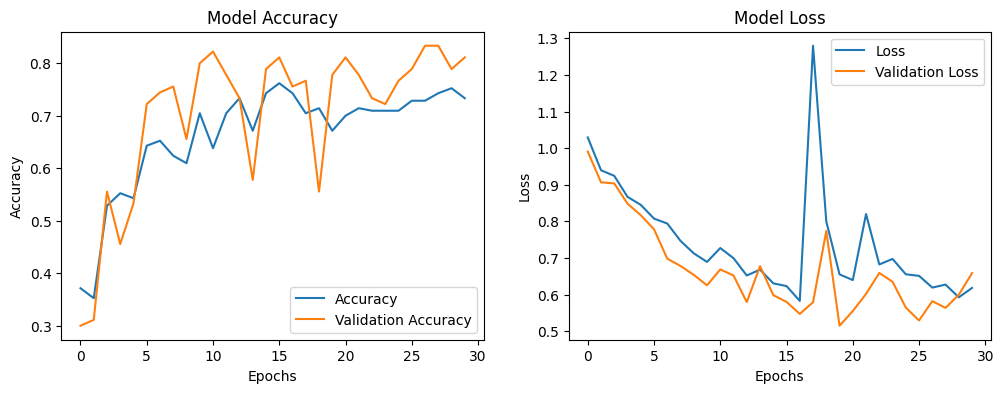

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/With_Options.keras ✅


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time
import pywt  # Importing PyWavelets for wavelet decomposition

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply Wavelet Decomposition (db4, level 5)
def wavelet_decomposition(data, wavelet='db4', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Use only the approximation coefficients (first element in coeffs list)
    return coeffs[0]  # You can also concatenate all coefficients for more information

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition on all data
    data_all_wavelet = np.array([wavelet_decomposition(sample) for sample in data_all])

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=3)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all_one_hot, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')  # Weighted recall
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp6/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")




Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.2915 - loss: 1.0474 - val_accuracy: 0.3000 - val_loss: 0.9825
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3427 - loss: 0.9634 - val_accuracy: 0.4556 - val_loss: 0.9236
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4827 - loss: 0.9066 - val_accuracy: 0.4889 - val_loss: 0.9122
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5117 - loss: 0.8939 - val_accuracy: 0.4444 - val_loss: 0.8526
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5472 - loss: 0.8505 - val_accuracy: 0.5889 - val_loss: 0.7843
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5830 - loss: 0.7970 - val_accuracy: 0.7667 - val_loss: 0.7083
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6435 - loss: 0.7496 - val_accuracy: 0.7667 - val_loss: 0.6438
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6887 - loss: 0.6767 - val_accuracy: 0.6556 - val_loss: 0.6564
Epoch 9/30

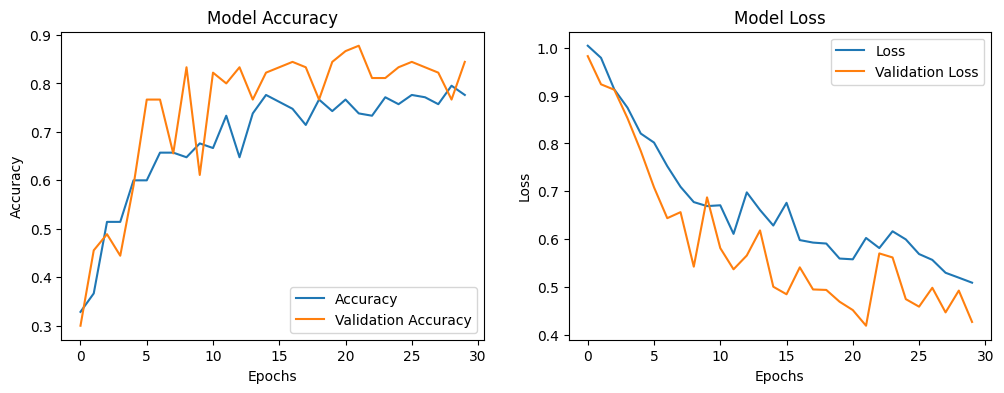

In [ ]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Wavelet transform function (db4, level 5)
def wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Keep only the approximation coefficients (the first element)
        transformed_data.append(coeffs[0])  # Use only the approximation coefficients
    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition (db4, level 5)
    data_all_wavelet = wavelet_transform(data_all, wavelet='db4', level=5)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=3)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all_one_hot, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')  # Weighted recall
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")
